# Regression Models

## Imports

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.metrics import mean_squared_error

from yellowbrick.regressor import PredictionError

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nbimporter

import TrainTestEvalSplit as split
from sklearn.model_selection import KFold

import pickle
from sklearn.utils import check_X_y

## Import File

In [15]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,weekday,is_weekend,Sensor,SensorLongitude,SensorLatitude,CrowdednessCount,Lon_4.8971927,Lon_4.8973336,...,Year,day_sin,day_cos,hour_sin,hour_cos,Nieuwmarkt score,Nieuwezijds Kolk score,Dam score,Spui score,Centraal Station score
0,2018-03-11,100,6.0,1.0,GAWW-04,4.897908,52.373283,886,0,0,...,2018,0.188227,0.982126,0.258819,0.965926,0.000000,0.000000,102.996844,0.000000,472.993853
1,2018-03-11,2100,6.0,1.0,GAWW-07,4.900441,52.374414,1603,0,0,...,2018,0.188227,0.982126,-0.707107,0.707107,346.998829,198.995171,1266.930956,133.989730,3859.981463
2,2018-03-11,2100,6.0,1.0,GAWW-08,4.897193,52.371650,21,1,0,...,2018,0.188227,0.982126,-0.707107,0.707107,346.997145,198.996668,1266.966573,133.995346,3859.909232
3,2018-03-11,2100,6.0,1.0,GAWW-09,4.898479,52.375040,88,0,0,...,2018,0.188227,0.982126,-0.707107,0.707107,346.997014,198.997601,1266.952991,133.991938,3859.978146
4,2018-03-11,2100,6.0,1.0,GAWW-10,4.898808,52.372369,49,0,0,...,2018,0.188227,0.982126,-0.707107,0.707107,346.998943,198.995907,1266.951383,133.993174,3859.941786


## Train/Test/Eval split

In [16]:
size = 0.9
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [17]:
x_train, y_train, x_test, y_test, train_dates = split.trainTestSplit(full_df, size)

## Models

### Baseline: Linear Regression
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

#### Training

In [18]:
base = LinearRegression(n_jobs=10, normalize=True)

In [19]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    base.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    mean_score += base.score(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])
    
    y_pred_base = base.predict(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_base, 
                                            y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"]))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.5681578427879074
Average RMSE Score:  645.0243938905207


#### Test

R^2 Score:  0.5745829015789017
RMSE:  628.8430832680315


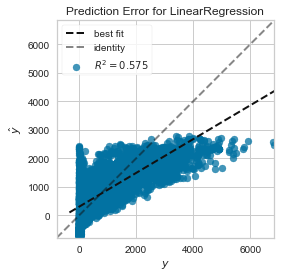

In [20]:
test_base_score = base.score(x_test, y_test)

y_pred_test_base = base.predict(x_test)
test_base_mse = mean_squared_error(y_pred_test_base, y_test)

print("R^2 Score: ", test_base_score)
print("RMSE: ", np.sqrt(test_base_mse))

visualizer = PredictionError(base)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

### Random Forrest Regressor 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

#### Training

In [21]:
rfg = RandomForestRegressor(n_estimators=500, criterion="mse", n_jobs=100, random_state=42, bootstrap=True, 
                               oob_score=True)

In [22]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    rfg.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    mean_score += rfg.score(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])
    
    y_pred_rfg = rfg.predict(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_rfg, 
                                            y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"]))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.8174907511701344
Average RMSE Score:  416.3158855099665


#### Test

R^2 Score:  0.831666473711437
RMSE:  395.56706816549956


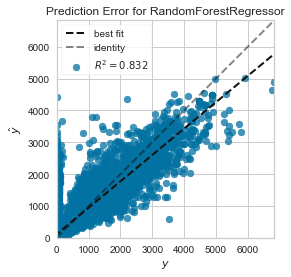

In [23]:
test_rfg_score = rfg.score(x_test, y_test)

y_pred_test_rfg = rfg.predict(x_test)
test_rfg_mse = mean_squared_error(y_pred_test_rfg, y_test)

print("R^2 Score: ", test_rfg_score)
print("RMSE: ", np.sqrt(test_rfg_mse))

visualizer = PredictionError(rfg)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

#### Save Model

In [16]:
filename = "../../../Data_thesis/Models/rfg_model.sav"

pickle.dump(rfg, open(filename, 'wb'))

### XGBoost Regressor
Through [SciKit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 

#### Training

In [11]:
xgbr = xgb.XGBRegressor(max_depth=6, learning_rate=0.08, n_estimators=500, verbosity=1,
                          booster="gbtree", n_jobs=50, random_state=42)

In [12]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    
    x_train_con, y_train_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
                                        y=y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    xgbr.fit(x_train_con,y_train_con)
    
    x_val_con, y_val_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
                                        y=y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])
    
    mean_score += xgbr.score(x_val_con,y_val_con)
    
    y_pred_xgbr = xgbr.predict(x_val_con)
    mean_rmse += np.sqrt(mean_squared_error(y_pred_xgbr,y_val_con))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.8266354773156328
Average RMSE Score:  404.7650130646047


#### Test

R^2 Score:  0.8199316630685494
RMSE:  409.1226225694469


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


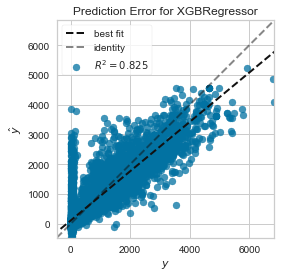

In [13]:
x_test_con, y_test_con = check_X_y(X=x_test, y=y_test)

test_xgbr_score = xgbr.score(x_test_con, y_test_con)

y_pred_test_xgbr = xgbr.predict(x_test_con)
test_xgbr_mse = mean_squared_error(y_pred_test_xgbr, y_test_con)

print("R^2 Score: ", test_xgbr_score)
print("RMSE: ", np.sqrt(test_xgbr_mse))

visualizer = PredictionError(xgbr)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"]) # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

#### Save model to File

In [18]:
filename = "../../../Data_thesis/Models/xgbr_model.sav"

pickle.dump(xgbr, open(filename, 'wb'))